In [1]:
from datasets import load_dataset, Dataset
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from tabulate import tabulate
from tqdm import trange
import random
from transformers import DataCollatorWithPadding

from transformers import AutoTokenizer
import json

In [2]:
#load model
model = BertForSequenceClassification.from_pretrained("models/model_mrda_v2_fewshot_t1.model/")

# labels =  ["dummy", "question", "validate", "reject", "unsure", "backchannel", "self-talk", "communication"]
# labels = [ "dummy", "state", "external source", "validate", "reject", "inquire", "direct"]
labels = ["statement", "disruption", "backchannel", "follow-me", "question"]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

In [3]:
#quick prototyping using sed, TODO change to python re module
import subprocess
import os

import re
from dateutil import parser

cwd = os.getcwd()

nek19_chat_df = pd.DataFrame()

for session in range(1,9):
    f_cmd = cwd + '/data/Project_RED/Cost\ of\ Conflict/chat\ log\ data/NEK19_{}.txt'.format(session)
    f = re.sub(r"\\", "", f_cmd)
    f_out_cmd = f_cmd + '.mod'
    f_out = re.sub(r"\\", "", f_out_cmd)
    cmd = cwd + '/convert_nek.sh {} {}'.format(f_cmd, f_out_cmd)
    out = subprocess.run(cmd, shell=True, capture_output=True).stdout

    s_df = pd.read_json(f_out)
    s_df = s_df.drop(columns=['_id', 'timeZone'])
    s_df['creationDateTime'] = s_df['creationDateTime'].apply(parser.parse)
    delt = s_df['creationDateTime'].iloc[-1]  - s_df['creationDateTime'].iloc[0]
    delt/3
    def aux(time):
        if(time < s_df['creationDateTime'].iloc[0] + delt/3): 
            return 0
        elif(time < s_df['creationDateTime'].iloc[0] + 2*delt/3):
            return 1
        else:
            return 2
    s_df['time'] = s_df['creationDateTime'].map(aux)
    s_df['session'] = session
    nek19_chat_df = pd.concat([nek19_chat_df, s_df])
nek19_chat_df = nek19_chat_df.drop('creationDateTime',axis=1).reset_index(drop=True)
nek19_chat = Dataset.from_pandas(nek19_chat_df)

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preproccess(samples):
    encoding = tokenizer.encode_plus(samples['content'], add_special_tokens = True,
                        max_length = 32,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        truncation=True,
                        padding="max_length")
        
    samples['input_ids'] = encoding['input_ids']
    samples['token_type_ids'] = encoding['token_type_ids']
    samples['attention_mask'] = encoding['attention_mask']
    return samples

nek19_chat = nek19_chat.map(preproccess)
nek19_chat.set_format('torch')

Map:   0%|          | 0/426 [00:00<?, ? examples/s]

In [5]:
from torch import tensor


def classify(samples):
    out = model(samples['input_ids'], token_type_ids=samples['token_type_ids'], attention_mask=samples['attention_mask'])
    logits = out.logits.detach().cpu().numpy()

    samples['logits'] = logits[0]
    # samples['labels_h'] = labels[logits.argmax()]
    samples['labels_h'] = labels[logits.argmax()-1]
    samples['labels'] = logits.argmax()
    # if(re.match("^.*lease confirm when.*$", samples['content'])):
    #     samples['labels'] = tensor(0)
    #     samples['labels_h'] = 'dummy'
    return samples
nek19_chat = nek19_chat.map(classify)

Map:   0%|          | 0/426 [00:00<?, ? examples/s]

In [6]:
# Taken from megans code
from pathlib import Path
from string import punctuation



tran_path = Path('data/Project_RED/Cost of Conflict/transcript data/NEK19/')
tran_list = list(tran_path.glob('*.txt'))
transcripts = {}
time = 0
for filepath in tran_list:
    name = Path(filepath).stem
    with open(filepath,'r',encoding='utf-8') as my_file:
        data = my_file.readlines()
        clean = []
        if "MAG" in name:
            for line in data:
                if line[:1].isalpha() == True and "Joy " not in line[:4]:
                    clean.append(line)
        else:
            for line in data:
                if ":" in line and line[:1].isnumeric() == False:
                    clean.append(line.strip() + "&&" +  str(time))
                elif ":" in line and line[:1].isnumeric() == True:
                    time +=1
        transcripts[name] = clean

def check_trans(word_list, messages):
    all_words = {}
    counter = {} # includes actual words from conversation
    dict_counter = {} # includes words from dictionary
    
    for message in messages:
        content = message.split(" ")
        for word in content:
            word = word.strip(punctuation).lower()
            if len(word)>1:
                if word in all_words:
                    all_words[word] += 1
                elif word.isalpha() == True:
                    all_words[word] = 1
                else:
                    if word[0].isnumeric() == False:
                        for symbol in punctuation:
                            if symbol in word:
                                split_word = word.split(symbol)
                                for section in split_word:
                                    if len(section) > 1:
                                        if word in all_words:
                                            all_words[word] += 1
                                        else:
                                            if word.isalpha() == True:
                                                all_words[word] = 1
                for check in word_list:
                    find = re.match(check, word)
                    if find != None:
                        if check[-1] != "*":
                            if len(word) > find.span()[1]:
                                continue
                        else:
                            if len(word) < len(check):
                                continue
                        if word not in counter:
                            counter[word] = 1
                        else:
                            counter[word] += 1
                        if check not in dict_counter:
                            dict_counter[check] = 1
                        else:
                            dict_counter[check] += 1
    return counter, dict_counter, all_words


In [7]:
# session = transcripts[list(transcripts.keys())[0]]
last_time = 0
nek19_trans_df = pd.DataFrame()
for session in transcripts:
   s_df = pd.DataFrame.from_dict(transcripts[session])
   def trans_proccess(c): 

      global g_time
      x=c[0].strip()
      # print(x)
      try:
         speaker = re.search(r"^[^:]*:\s*", x).group()[:-2]
      except:
         speaker = ""
      try:
         content = re.search(r":(.*)&&", x).group()[1:-2]
      except:
         content = ""
      try:
         time = int(re.search(r"&&.*", x).group()[2:])
         g_time = time
      except:
         time = -1

      if(speaker == "" and content == ""):
         speaker = None
         content = None

      row = pd.Series()

      row['speaker'] = speaker
      row['content'] = content
      row['block'] = time-last_time 
      row['session'] = session
      return row
   nek19_trans_df = pd.concat([nek19_trans_df, s_df.apply(lambda x: trans_proccess(x), axis=1)])
   last_time = g_time
   # print(str(session) + ": " + str(last_time))
nek19_trans_df = nek19_trans_df.dropna()
nek19_trans_df = nek19_trans_df[nek19_trans_df['block'] >= 0].reset_index(drop=True)
nek19_trans_df['block'] = (nek19_trans_df['block'] / nek19_trans_df['block'].max() * 10).apply(int)
nek19_trans_df

/tmp/ipykernel_2082558/672122092.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  row = pd.Series()
/tmp/ipykernel_2082558/672122092.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  row = pd.Series()
/tmp/ipykernel_2082558/672122092.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  row = pd.Series()
/tmp/ipykernel_2082558/672122092.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  row = pd.Series()
/tmp/ipykernel_2082558/672122092.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead o

,speaker,content,block,session
0,Nastya,Ninety and slash or?,0,3
1,Ryan to Zheny,And then just your number. So [UI],0,3
2,Natash,No…,0,3
3,Zheny,[UI],0,3
4,Ali,You have a password.,0,3
...,...,...,...,...
6260,Nastya,How many for you?,8,1
6261,Dasha,Two please.,8,1
6262,Nastya,Here you go.,8,1
6263,Dasha,Thank you so much.,8,1


In [8]:
# categorize

for session in transcripts:
    s = nek19_trans_df[nek19_trans_df['session'] == session]
    delt = s['block'].max()
    s['time'] = 2
    s.loc[s['block'] < 2*delt/3, 'time']= 1
    s.loc[s['block'] < delt/3, 'time']= 0
    nek19_trans_df.loc[nek19_trans_df['session'] == session,'time'] = s['time']
# nek19_trans_df =nek19_trans_df.drop('block', axis=1)

/tmp/ipykernel_2082558/677723469.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s['time'] = 2
/tmp/ipykernel_2082558/677723469.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s['time'] = 2


In [9]:
nek19_trans_df['content'].apply(len).mean()

32.38483639265762

In [10]:
nek19_trans = Dataset.from_pandas(nek19_trans_df)

In [11]:
nek19_trans = nek19_trans.map(preproccess)
nek19_trans.set_format('torch')

nek19_trans = nek19_trans.map(classify)

Map:   0%|          | 0/6265 [00:00<?, ? examples/s]

Map:   0%|          | 0/6265 [00:00<?, ? examples/s]

In [12]:
# Check accuracy by taking a random sample of 20 (10 translated, 10 msgs)

import random 
from operator import itemgetter

n = 10
trans_sample_ind = random.sample(range(0, len(nek19_trans)), n)
chat_sample_ind = random.sample(range(0, len(nek19_chat)), n)
samples = pd.DataFrame(columns=['content', 'model_label', 'human_label', 'source'])
# pd.concat([
#     pd.DataFrame.from_dict(nek19_trans[trans_sample]),
#     pd.DataFrame.from_dict(nek19_chat[chat_sample])
#                  ])

trans_sample = itemgetter(*trans_sample_ind)(nek19_trans)
chat_sample = itemgetter(*chat_sample_ind)(nek19_chat)
samples = pd.DataFrame(columns=["source", "content", "label"])

for t in trans_sample:
    samples.loc[len(samples.index)] = ["spoken", t['content'], t['labels_h']]

for c in chat_sample:
    samples.loc[len(samples.index)] = ["chat", c['content'], c['labels_h']]

print("Unique Labels in Set: " + str(len(pd.unique(samples['label']))))
samples.to_csv('samples.csv')
samples

Unique Labels in Set: 3


,source,content,label
0,spoken,[SL] Didn’t get lost.,question
1,spoken,Just to cheer him up.,question
2,spoken,[UI],statement
3,spoken,So… Sirius team too…,question
4,spoken,Maybe here I need to take…,question
5,spoken,You can translate //that stuff yourselves.,question
6,spoken,You guess… you guess it… mhm.,question
7,spoken,Yeah.,question
8,spoken,//Why can’t I see who I wrote to… [UI]?,follow-me
9,spoken,"[UI] so, I will send it to you. You send it t...",question


In [19]:
nek19_trans_df = nek19_trans.to_pandas()
for i in range(0, len(labels)):
    content = "__NONE__"
    df = nek19_trans_df[nek19_trans_df['labels'] == i]['content']
    if(len(df.index) > 0):
        rand_sample_ind = random.randint(0, len(df.index)-1)
        if(rand_sample_ind >= 0):
            content = df.iloc[random.randint(0, len(df.index)-1)]

    print_str = labels[i] + ": " + str(len(df.index)) + " : " + content
    print(print_str)


statement: 3764 : I’m just checking to…
disruption: 707 :  //[UI]
backchannel: 125 : Mhm.
follow-me: 0 : __NONE__
question: 1669 : What?


In [20]:
nek19_trans_df = nek19_trans.to_pandas()
for i in range(0, len(labels)):
    content = "__NONE__"
    df = nek19_trans_df[nek19_trans_df['labels'] == i]['content']
    if(len(df.index) > 0):
        rand_sample_ind = random.randint(0, len(df.index)-1)
        if(rand_sample_ind >= 0):
            content = df.iloc[random.randint(0, len(df.index)-1)]

    print_str = labels[i] + ": " + str(len(df.index)) + " : " + content
    print(print_str)


statement: 3764 : Yes, I know, but something happened.
disruption: 707 :  //[UI]
backchannel: 125 : Mhm.
follow-me: 0 : __NONE__
question: 1669 : Do we have the [PH] Relay after this?


In [21]:
#load in perf data for NEK19
perf_df = pd.read_csv('data/Project_RED/calculated performance data/NEKMTSCalcs.csv')
perf_df

,Mission,Measure,min/max,MoM,MTSPerf
0,NEK1S1,MTS Score,max,0.62,0.008
1,NEK1S2,MTS Score,max,0.03,0.000
2,NEK1S3,MTS Score,max,0.56,1.000
3,NEK1S4,MTS Score,max,0.51,0.976
4,NEK1S5,MTS Score,max,1.00,0.972
5,NEK1S6,MTS Score,max,1.00,0.952
6,NEK1S7,MTS Score,max,0.50,0.000
7,NEK1S8,MTS Score,max,0.96,0.151


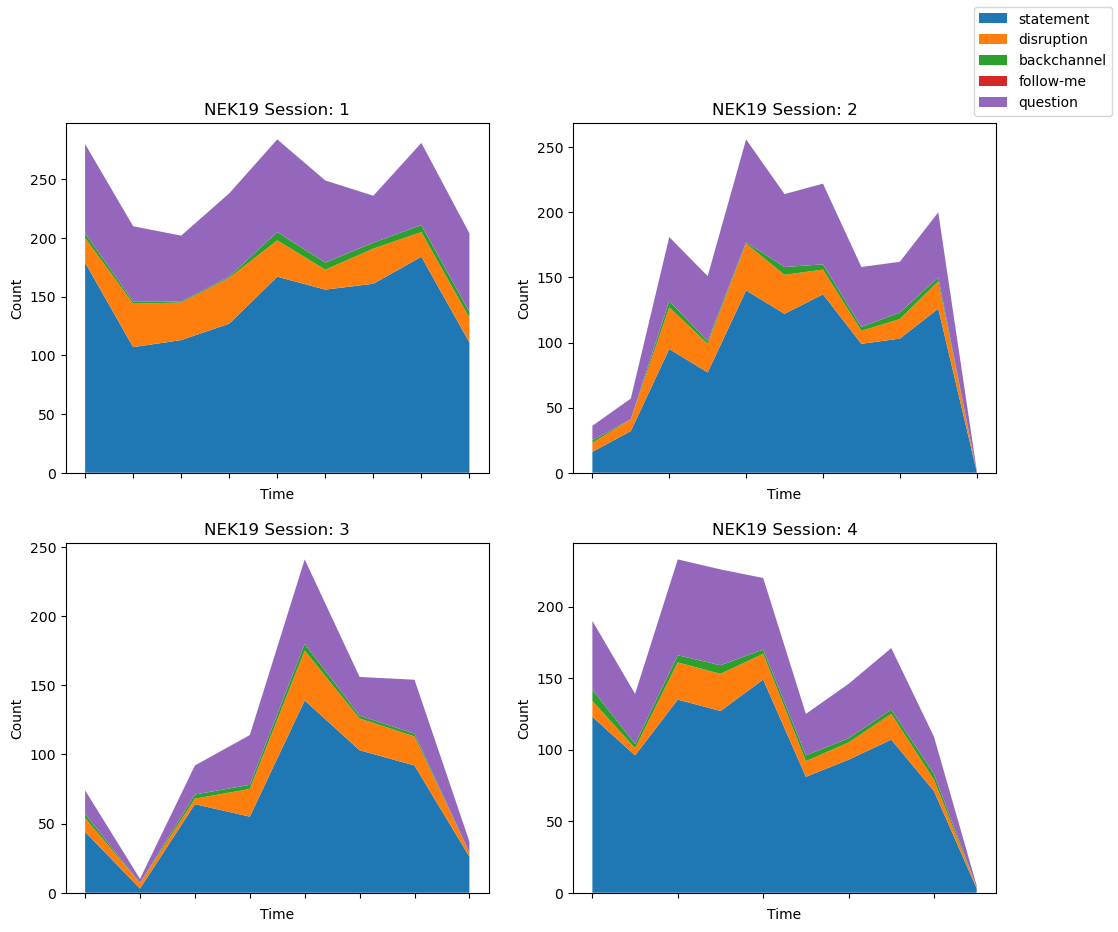

In [22]:
import matplotlib.ticker as mtick
import numpy as np
import matplotlib.pyplot as plt


n = len(transcripts.keys())
fig, axs = plt.subplots(2,2)

fig.set_size_inches(12,10)
session = 1
for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Count', title="NEK19 Session: " + str(session))
    ax.axes.xaxis.set_ticklabels([])
    df = nek19_trans_df[nek19_trans_df['session'] == str(session)]
    bs = range(0, len(df['block'].unique()))
    distss = []
    for i in range(0, len(labels)):
        #each block is approx 1-4 mins
        dists = []
        for b in bs:
            within_block = df[df['block'] == b]
            dists = dists + [len(within_block[within_block['labels'] == i].index)]
        distss = distss + [dists]
        # plt.title(labels[i] + ": " + str(session))
        # TODO: Volume graph with evetry __ timepoints; have 10ish points

    ax.stackplot(bs, distss)
    session += 1
fig.legend(labels)
fig.show()

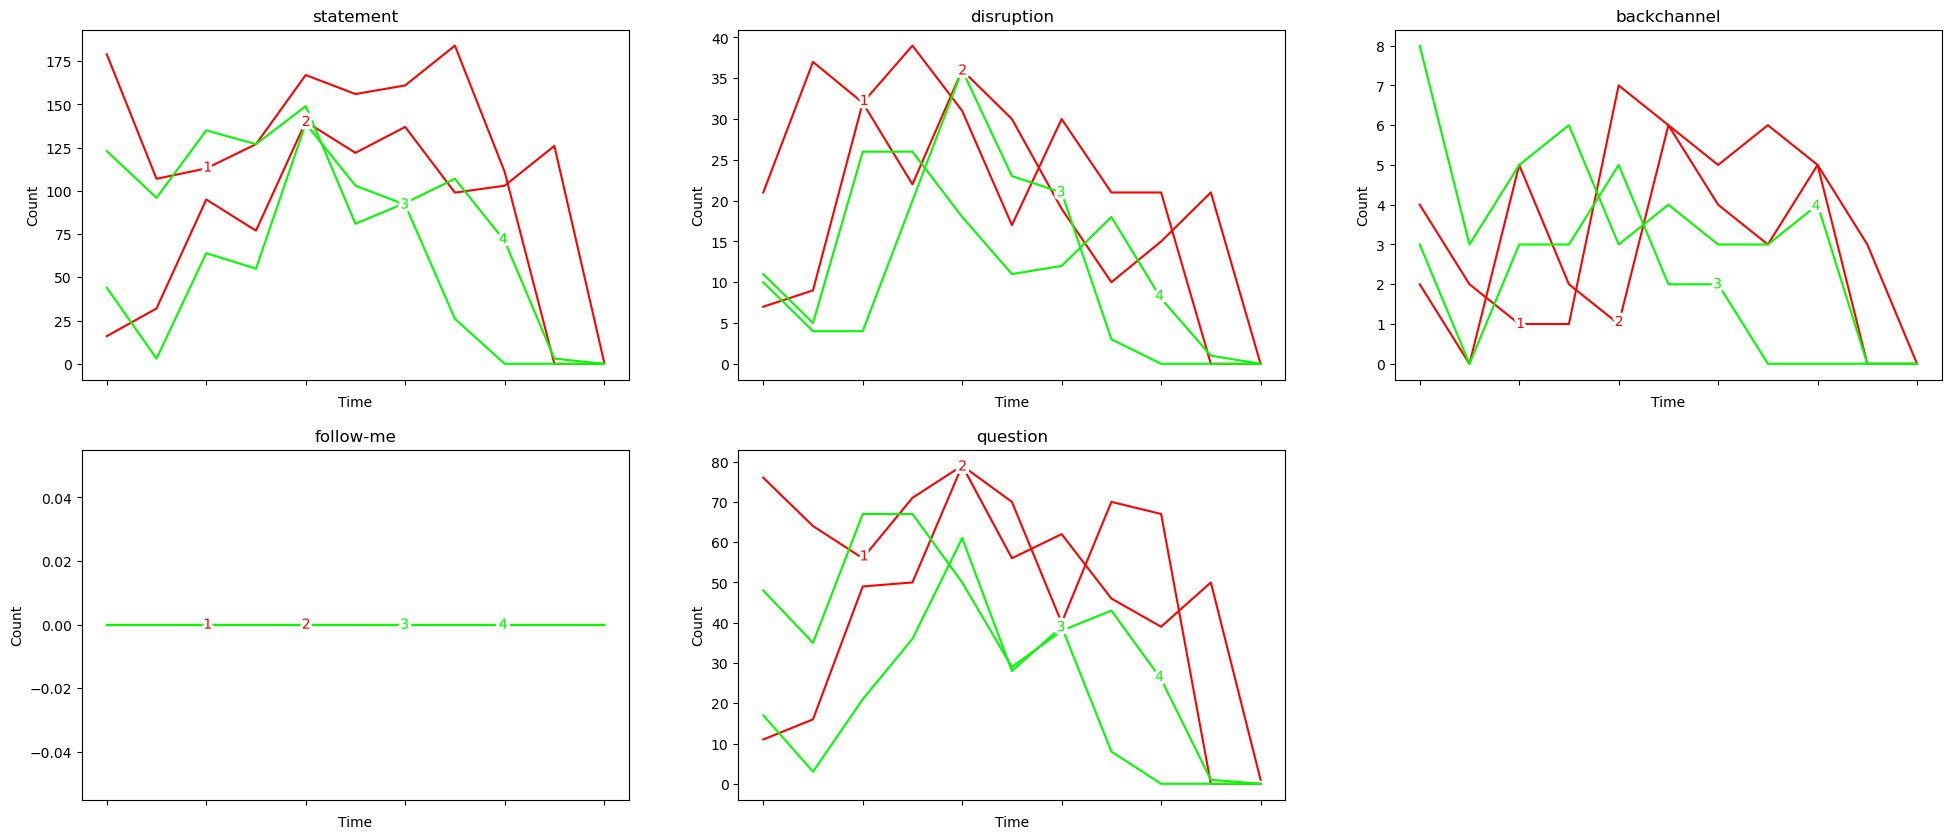

In [23]:
import matplotlib as mpl
from labellines import labelLine, labelLines
# fig, axs = plt.subplots(3,2)
bs = range(0, len(nek19_trans_df['block'].unique()))
i=0
fig = plt.figure()
fig.set_size_inches(24,10)
spec = mpl.gridspec.GridSpec(ncols=3, nrows=2)
def perf_gradient(score):
    return np.array([1, 0, 0]) * (1-score) + np.array([0, 1, 0]) * score
axs = [
    fig.add_subplot(spec[0, 0]),
    fig.add_subplot(spec[0, 1]),
    fig.add_subplot(spec[0, 2]),
    fig.add_subplot(spec[1, 0]),
    fig.add_subplot(spec[1, 1]),
]
for ax in axs:
    for session in range(1, n+1):
        ax.set(xlabel='Time', ylabel='Count', title=(labels[i]))
        ax.axes.xaxis.set_ticklabels([])
        matched_label = nek19_trans_df[nek19_trans_df['labels'] == i]
        df = matched_label[matched_label['session'] == str(session)]
        dist = []
        for b in bs:
            within_block = df[df['block'] == b]
            dist = dist + [len(within_block.index)]
        ax.plot(bs, dist, label=str(session), color=perf_gradient(perf_df['MTSPerf'].iloc[session-1]))
    i+=1
    labelLines(ax.get_lines(), yoffsets=0.00, align=False, zorder=2)
# legend = ["Session: " + str(x+1) for x in range(4)]
# 

In [18]:
# export results to csv
export_df = nek19_trans_df[['speaker', 'content', 'block', 'session', 'labels', 'labels_h']]
export_df.to_csv('results/nek19_trans_df.csv')